In [93]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

In [ ]:
# dataset non-linéaire 2D (idéal pour frontières non‑linéaires)
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Injecter NaN + imputer si nécessaire (même routine que toi)
missing_rate = 0.05
rng = np.random.RandomState(42)
n_missing = int(np.floor(missing_rate * X.size))
missing_idx = rng.choice(X.size, n_missing, replace=False)
rows, cols = np.unravel_index(missing_idx, X.shape)
X[rows, cols] = np.nan

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

feature_names = [f"feature_{i}" for i in range(X_imputed.shape[1])]
df = pd.DataFrame(X_imputed, columns=feature_names)
df["target"] = y
print(df.head())

   feature_0  feature_1  target
0  -0.111667   0.520224       1
1   1.142650  -0.342577       1
2   0.795558  -0.011442       1
3   0.111827  -0.551932       1
4  -0.816466   0.543996       0


In [95]:
# Génération d'un jeu simple : 1000 échantillons, 4 features (2 informatives)
# X, y = make_classification(
#     n_samples=1000,
#     n_features=4,
#     n_informative=2,
#     n_redundant=0,
#     n_repeated=0,
#     n_classes=2,
#     n_clusters_per_class=1,
#     class_sep=1.5,
#     flip_y=0.01,
#     random_state=42
# )

# # Injecter des valeurs manquantes (ex. 5%) de manière reproductible
# missing_rate = 0.05
# rng = np.random.RandomState(42)
# n_missing = int(np.floor(missing_rate * X.size))
# missing_idx = rng.choice(X.size, n_missing, replace=False)
# rows, cols = np.unravel_index(missing_idx, X.shape)
# X[rows, cols] = np.nan

# # Imputation des valeurs manquantes (strategy='mean' par défaut)
# imputer = SimpleImputer(strategy="mean")
# X_imputed = imputer.fit_transform(X)

# # DataFrame pour faciliter l'inspection
# feature_names = [f"feature_{i}" for i in range(X.shape[1])]
# df = pd.DataFrame(X_imputed, columns=feature_names)
# df["target"] = y

# print(df.head())

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names], df["target"],
    test_size=0.3,
    stratify=df["target"],
    random_state=42
)

# Affichage rapide des dimensions et de l'équilibre des classes
print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)
print("Classes (train):\n", y_train.value_counts(normalize=True))
print("Classes (test):\n", y_test.value_counts(normalize=True))

Shapes -> X_train: (700, 2) X_test: (300, 2)
Classes (train):
 target
1    0.5
0    0.5
Name: proportion, dtype: float64
Classes (test):
 target
1    0.5
0    0.5
Name: proportion, dtype: float64


In [97]:
# Utiliser uniquement les deux premières features pour l'entrainement + visualisation
f0, f1 = feature_names[0], feature_names[1]
X_train_2 = X_train[[f0, f1]].values
X_test_2 = X_test[[f0, f1]].values

# Entraînement du Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_2, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [98]:
# Prédictions & accuracy
y_pred = rf.predict(X_test_2)
acc = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy (2 features): {acc:.4f}")

Random Forest accuracy (2 features): 0.9533


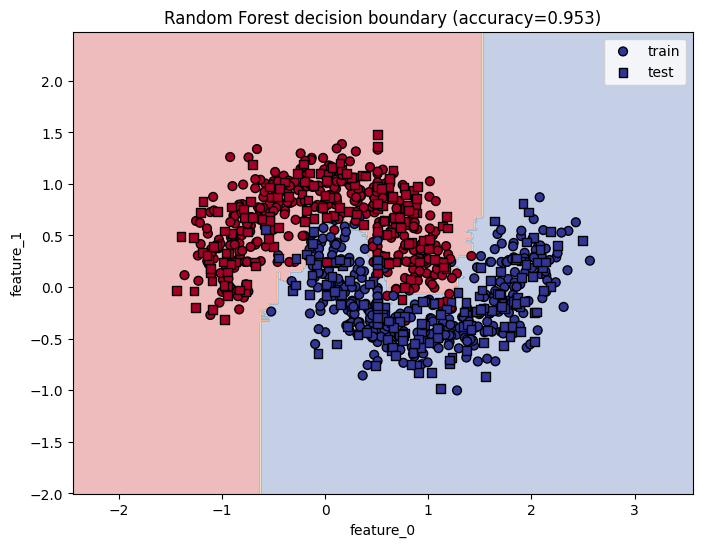

In [99]:
# Construction d'une grille couvrant l'espace des deux features
pad = 1.0
x_min, x_max = np.min(np.r_[X_train_2[:,0], X_test_2[:,0]]) - pad, np.max(np.r_[X_train_2[:,0], X_test_2[:,0]]) + pad
y_min, y_max = np.min(np.r_[X_train_2[:,1], X_test_2[:,1]]) - pad, np.max(np.r_[X_train_2[:,1], X_test_2[:,1]]) + pad
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prédictions sur la grille
grid_preds = rf.predict(grid_points)
zz = grid_preds.reshape(xx.shape)

# Tracé de la frontière de décision + points d'entrainement et de test
fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.cm.RdYlBu
ax.contourf(xx, yy, zz, alpha=0.3, cmap=cmap)
scatter = ax.scatter(X_train_2[:,0], X_train_2[:,1], c=y_train, cmap=cmap, edgecolor='k', marker='o', label='train', s=40)
ax.scatter(X_test_2[:,0], X_test_2[:,1], c=y_test, cmap=cmap, edgecolor='k', marker='s', label='test', s=40)
ax.set_xlabel(f0)
ax.set_ylabel(f1)
ax.set_title(f"Random Forest decision boundary (accuracy={acc:.3f})")
ax.legend()
plt.show()

In [100]:
# Gradient Boosting sur les deux premières features (visualisation + évaluation)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train_2, y_train)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [101]:
# Prédictions & accuracy
y_pred_gb = gb.predict(X_test_2)
acc_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting accuracy (2 features): {acc_gb:.4f}")

Gradient Boosting accuracy (2 features): 0.9500


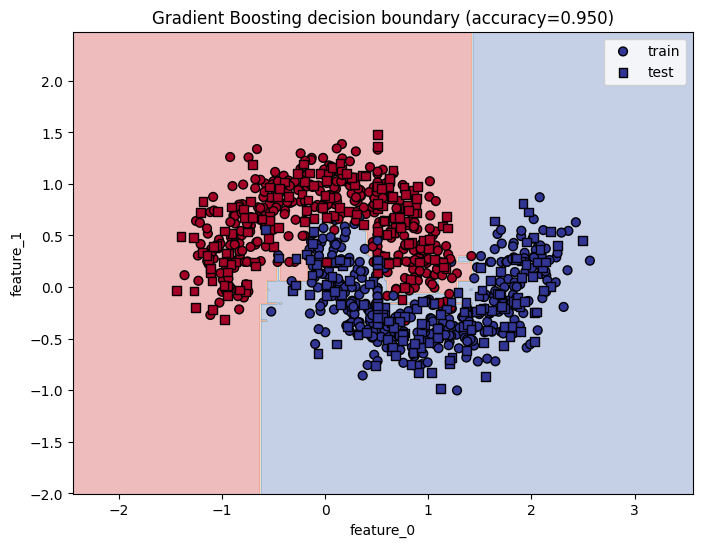

In [102]:
# Construction d'une grille couvrant l'espace des deux features (mêmes bornes que pour RF)
pad = 1.0
x_min, x_max = np.min(np.r_[X_train_2[:,0], X_test_2[:,0]]) - pad, np.max(np.r_[X_train_2[:,0], X_test_2[:,0]]) + pad
y_min, y_max = np.min(np.r_[X_train_2[:,1], X_test_2[:,1]]) - pad, np.max(np.r_[X_train_2[:,1], X_test_2[:,1]]) + pad
xx_gb, yy_gb = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid_points_gb = np.c_[xx_gb.ravel(), yy_gb.ravel()]

# Prédictions sur la grille
grid_preds_gb = gb.predict(grid_points_gb)
zz_gb = grid_preds_gb.reshape(xx_gb.shape)

# Tracé de la frontière de décision + points d'entrainement et de test
fig_gb, ax_gb = plt.subplots(figsize=(8,6))
cmap = plt.cm.RdYlBu
ax_gb.contourf(xx_gb, yy_gb, zz_gb, alpha=0.3, cmap=cmap)
ax_gb.scatter(X_train_2[:,0], X_train_2[:,1], c=y_train, cmap=cmap, edgecolor='k', marker='o', label='train', s=40)
ax_gb.scatter(X_test_2[:,0], X_test_2[:,1], c=y_test, cmap=cmap, edgecolor='k', marker='s', label='test', s=40)
ax_gb.set_xlabel(f0)
ax_gb.set_ylabel(f1)
ax_gb.set_title(f"Gradient Boosting decision boundary (accuracy={acc_gb:.3f})")
ax_gb.legend()
plt.show()

In [103]:
# XGBoost sur les deux premières features (visualisation + évaluation)
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train_2, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [104]:
# Prédictions & accuracy
y_pred_xgb = xgb.predict(X_test_2)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost accuracy (2 features): {acc_xgb:.4f}")

XGBoost accuracy (2 features): 0.9567


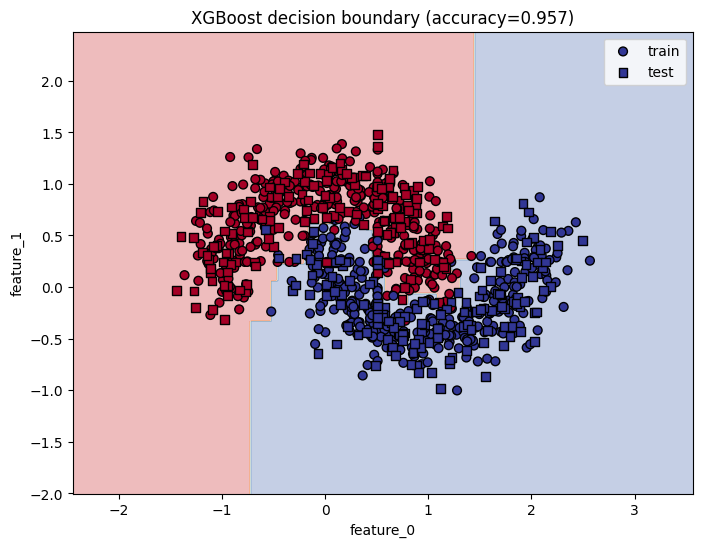

In [105]:
# Construction d'une grille couvrant l'espace des deux features (mêmes bornes)
pad = 1.0
x_min, x_max = np.min(np.r_[X_train_2[:,0], X_test_2[:,0]]) - pad, np.max(np.r_[X_train_2[:,0], X_test_2[:,0]]) + pad
y_min, y_max = np.min(np.r_[X_train_2[:,1], X_test_2[:,1]]) - pad, np.max(np.r_[X_train_2[:,1], X_test_2[:,1]]) + pad
xx_xgb, yy_xgb = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid_points_xgb = np.c_[xx_xgb.ravel(), yy_xgb.ravel()]

# Prédictions sur la grille
grid_preds_xgb = xgb.predict(grid_points_xgb)
zz_xgb = grid_preds_xgb.reshape(xx_xgb.shape)

# Tracé de la frontière de décision + points d'entrainement et de test
fig_xgb, ax_xgb = plt.subplots(figsize=(8,6))
cmap = plt.cm.RdYlBu
ax_xgb.contourf(xx_xgb, yy_xgb, zz_xgb, alpha=0.3, cmap=cmap)
ax_xgb.scatter(X_train_2[:,0], X_train_2[:,1], c=y_train, cmap=cmap, edgecolor='k', marker='o', label='train', s=40)
ax_xgb.scatter(X_test_2[:,0], X_test_2[:,1], c=y_test, cmap=cmap, edgecolor='k', marker='s', label='test', s=40)
ax_xgb.set_xlabel(f0)
ax_xgb.set_ylabel(f1)
ax_xgb.set_title(f"XGBoost decision boundary (accuracy={acc_xgb:.3f})")
ax_xgb.legend()
plt.show()